In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib.request # Download images
from PIL import *   # Read image
from langdetect import detect # Books only in english

import git # To clone and download the csv files

from bs4 import BeautifulSoup # For web scraping
import requests # For web scraping
import json # For web scraping
import re # Regex

from time import time 
import shutil # To remove folders
import os
import warnings
warnings.filterwarnings('ignore')

from myfunk import *

%matplotlib inline

Using TensorFlow backend.


In [3]:
## ---- Variables
# Check Path

project_name = 'book_cover_recommender'

if not os.getcwd().endswith(project_name):
    try: 
        ind = os.getcwd().index(project_name)
        idx = len(os.getcwd()) - (ind+len(project_name))
        path = os.getcwd()[:-idx]
        print(path)
        os.chdir(path)

    except:
        print('{} not found in path'.format(project_name))
else: 
    path = os.getcwd()
    print(path)
    

/Users/iZbra1/Documents/K2DS/Projects/book_cover_recommender


In [4]:
## ----  Web scraping:  ~ 1 min

try: 
    # See if the 5 csv files are already in the external folder
    
    assert len([f for f in glob.glob(path+"/data/external/*.csv")]) == 5
    print('CSV files are already in place', pd.read_csv(path+"/data/external/books.csv").shape)

    
except:
    # Get the data from goodreads 10k
    # https://github.com/zygmuntz/goodbooks-10k.git
    # save the csv files in ~/data/external

    start = time()
    download_data_from_goodbooks(path)
    print(time()-start,'seconds processed')

CSV files are already in place (10000, 23)


In [4]:
## --- Preprocessing: ~ 20 s
# Preprocess the csv files from the ~data/external folder 
# and save them in ~data/raw folder

start = time()
preprocess_goodbooks(path)
print(time()-start,'seconds processed')

Preprocessing 10000 books
Found 8142 books officially in english.
Running the english detector for the rest
Detector found 861 more books in english
Preprocessed 9003 books
Preprocessed 999912 book_tags
19.1336510181427 seconds processed


In [ ]:
## ----- Upload the csv files to the sql instance

# df = pd.read_csv(path+'data/interim/books.csv', index_col=0)
# insert_db(df, 'books', engine)
# print('Uploaded: books')
# df2 = pd.read_csv(path+'data/external/ratings.csv', index_col=0)
# insert_db(df2, 'ratings', engine)
# print('Uploaded: ratings')
# df3 = pd.read_csv(path+'data/external/to_read.csv', index_col=0)
# insert_db(df3, 'to_read', engine)
# print('Uploaded: to_read')
# df4 = pd.read_csv(path+'data/external/tags.csv', index_col=0)
# insert_db(df4, 'tags', engine)
# print('Uploaded: tags')
# df5 = pd.read_csv(path+'data/external/book_tags.csv', index_col=0)
# insert_db(df5, 'book_tags', engine)
# print('Uploaded: book tags')
# print('insert_db done')

In [5]:
df = pd.read_csv(path+'/data/raw/books.csv', index_col=0)
print(df.shape)
df.tail(2)

(9003, 7)


,isbn,authors,year,title,average_rating,ratings_count,image_url
book_id,,,,,,,
9999,61711527,peggy orenstein,2011,cinderella ate my daughter dispatches from the...,3.65,11279,https://images.gr-assets.com/books/1279214118m...
10000,375700455,john keegan,1998,the first world war,4.00,9162,https://images.gr-assets.com/books/1403194704m...


### Check book covers or download them

In [6]:
punctuation_pattern = r"[^\w\s]"

# Function that formats image filenames into the standard format
format_cover_file = lambda x: re.sub(punctuation_pattern, '', unidecode.unidecode(x).lower().strip())

# Function that returns True if the image file exists. 
sync = lambda x: os.path.isfile(os.getcwd()+'/'+x.title+" by "+x.authors+".jpg")

# Download Book Covers from image_url
def get_cover(row):
    filename = row.title+' by '+row.authors+'.jpg'
    try: 
        urllib.request.urlretrieve(row.image_url,filename)
    except: 
        print('image url not found: ', row.image_url)
        filename = 'Img not found'
    return filename

def format_image_filenames(cover_titles):
    for file in cover_titles:
    # Check if file exists
        if os.path.isfile(file+".jpg"):
#             print('Renaming..',file+".jpg")
            os.rename(file+".jpg", format_cover_file(file)+".jpg")
        else:
            print(file+".jpg doesnt exist/n")

def check_cover(x, df, pth):
    try: 
        os.chdir(pth)
        # Check if all covers have a reference in the dataframe
        cover_titles = [f[:-4] for f in glob.glob("*.jpg")]  
        number_of_covers = len(cover_titles)
        print('{} covers found'.format(number_of_covers))
        number_covers_reference = df.shape[0]
        # Apply format to cover files:  
        print('Checking filename Format')
        format_image_filenames(cover_titles)
    
    except Exception as e: 
        print('No covers found in {} drive:\n{}'.format(x,e))
        return 0 #'none'

    if not number_of_covers == number_covers_reference:
        print('There are {} out of {} book covers that couldnt be downloaded'.\
              format(number_covers_reference-number_of_covers, number_covers_reference))
        # Remove from the dataset
        df['cover_exists'] = df.apply(sync, axis=1)
        print('Removing {} instances from the dataset'.format(number_covers_reference-number_of_covers))
        df = df[df.cover_exists]
        # Column holding filename
        df['cover'] = df.apply(lambda x: x.title+' by '+x.authors+".jpg", axis=1)
        return df
    else: 
        print("Dataset is complete!",df.shape, number_of_covers)

In [7]:
print("Select Drive: [external/local/none]")
x = input()
if x == 'external':
    x = check_cover(x, df, '/Volumes/LEEGARE/Capstone')
elif x == 'local':
    # Local drive
    x = check_cover(x, df, path+"/data/external/covers")

if not isinstance(x,pd.core.frame.DataFrame):
    print('Downloading book covers... into {} ETA: 68 min for 9011 books | 45s for 100 books'.format(path))
# if os.getcwd()
    start = time() # 68 min for 9011 books | 45s for 100 books
    df['cover'] = df.apply(lambda row: get_cover(row), axis=1)
    print(time()-start, 's downloading', df.shape[0], 'book covers')


Select Drive: [external/local/none]
100 covers found
Checking filename Format
There are 8903 out of 9003 book covers that couldnt be downloaded
Removing 8903 instances from the dataset


In [8]:
# df.to_csv(path+'/data/interim/books.csv')
print("Covers saved")
df = pd.read_csv(path+'/data/interim/books_sample.csv', index_col=0)
df.shape

Covers saved


(100, 9)

In [319]:
# Get the RATINGS of the sample books: 
rat = pd.read_csv(path+"/data/raw/ratings.csv", index_col=0)
rat.loc[rat.book_id.isin(df.index)].to_csv(path+'/data/interim/ratings.csv')
print("Ratings saved")

Ratings saved


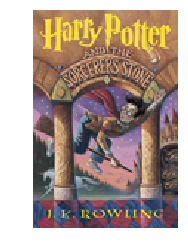

In [139]:
plt.imshow(np.array(Image.open(os.listdir()[1])))
plt.axis('off')
plt.show()